# Recurrent Neural Networks
Using an LSTM to predict the origin of names.

In [1]:
import numpy as np
import torch
from torch import nn
import requests
import zipfile
from io import BytesIO
import unicodedata
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import string


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


## Data Processing

### Collecting data

In [2]:
# Extract data
response = requests.get(
    'https://download.pytorch.org/tutorial/data.zip',
    verify=False
)

data, labels = [], []
with zipfile.ZipFile(BytesIO(response.content)) as zfile:
    for filename in [
        f 
        for f in zfile.namelist() 
        if f.endswith('.txt') and f.startswith('data/names')
    ]:
        with zfile.open(filename) as file:
            lines = file.read().decode('utf-8').strip().split('\n')
            names = [
                unicodedata.normalize(
                    'NFKD', 
                    line
                ).encode('ascii', 'ignore').decode('utf-8')
                for line in lines
            ]
            category = filename.split('/')[-1].split('.')[0]
            temp_labels = np.repeat(category, len(names))
            
            data.extend(names)
            labels.extend(temp_labels)
            

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.pytorch.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


### Label Encoding

In [3]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categories = label_encoder.classes_

def label_to_tensor(label, encoder):
    label = label if isinstance(label, list) else [label]
    return torch.LongTensor(
        encoder.transform(label).reshape(-1, 1)
    ).to(device)

np.vstack([categories, label_encoder.transform(categories)]).T

array([['Arabic', '0'],
       ['Chinese', '1'],
       ['Czech', '2'],
       ['Dutch', '3'],
       ['English', '4'],
       ['French', '5'],
       ['German', '6'],
       ['Greek', '7'],
       ['Irish', '8'],
       ['Italian', '9'],
       ['Japanese', '10'],
       ['Korean', '11'],
       ['Polish', '12'],
       ['Portuguese', '13'],
       ['Russian', '14'],
       ['Scottish', '15'],
       ['Spanish', '16'],
       ['Vietnamese', '17']], dtype='<U21')

### Name Encoding

In [4]:
dictionary = string.ascii_letters + " .,;'-/:" + '0123456789'

def name_to_tensor(name):
    tensor = torch.zeros(len(name), len(dictionary)).to(device)
    for i, char in enumerate(name):
        try:
            tensor[i][dictionary.index(char)] = 1
        except:
            raise ValueError(f'Character {char} not in dictionary')
    return tensor

name_to_tensor('Edy')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')

### Balancing Classes Within Each Batch

In [6]:
def sample_batch(data, labels, encoder, size):
    data = data.copy()
    labels = labels.copy()
    
    data_batch, labels_batch = [], []

    categories, _ = np.unique(labels, return_counts=True)

    for cat in categories:
        idxs_cat = [i for i, l in enumerate(labels) if l == cat]

        selected_idx = np.random.choice(idxs_cat, size=size, replace=True)

        
        data_sample = np.array(data)[selected_idx]
        labels_sample = np.array(labels)[selected_idx]      
        
        data_batch.extend(data_sample)
        labels_batch.extend(labels_sample)

    
    data_tns = [name_to_tensor(d) for d in data_batch]
    labels_tns = label_to_tensor(labels_batch, encoder=encoder)
    return data_tns, labels_tns

data_batch, rotulos_batch = sample_batch(
  data, labels, encoder=label_encoder, size=32
)

## LSTM

In [7]:
# Definition of the RNN model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.recurrent = nn.GRU(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.activation = nn.LogSoftmax(dim=1)

    def forward(self, name):
        
        h = torch.zeros(1, 1, self.hidden_size).to(device)
    
        name = name.unsqueeze(1)

        output, h = self.recurrent(name, h)
        output = self.output(output[-1])
        output = self.activation(output)

        return output

In [8]:
def forward(
        model, 
        criterion, 
        optimizer, 
        data, 
        labels,
        is_train=True
    ):

    if is_train:
        model.train()
    else:
        model.eval()

    loss_epoca = []

    for name, label in zip(data, labels):
        output = model(name)
        loss = criterion(output, label)
        loss_epoca.append(loss.detach().cpu().numpy())

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return np.array(loss_epoca).mean(), np.array(loss_epoca).std()

### Training and Testing

In [9]:
model = LSTM(len(dictionary), 512, len(categories))
model.to(device)

criterion = nn.NLLLoss().to(device)
optim_parameters = {
    'lr': 5e-5,
    'weight_decay': 1e-7
}
optimizer = torch.optim.Adam(model.parameters(), **optim_parameters)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

X_test_tns = [name_to_tensor(d) for d in X_test]
y_test_tns = label_to_tensor(y_test, encoder=label_encoder)


loss_train, loss_test = [], []
for epoch in range(200):
    X_train_batch, y_train_batch = sample_batch(data, labels, label_encoder, 32)
    
    loss_train_avg, loss_train_std = forward(
        model, 
        criterion, 
        optimizer, 
        X_train_batch, 
        y_train_batch
    )
    loss_train.append(loss_train_avg)
    
    loss_test_mean, loss_test_std = forward(
        model, 
        criterion, 
        optimizer, 
        X_test_tns, 
        y_test_tns, 
        is_train=False
    )
    loss_test.append(loss_test_mean)
    
    if epoch % 10 == 0:
        print('-' * 50)
        print(f'Epoch {epoch+1:03d}')
        print(f'|> Loss Train: {loss_train_avg:.4f} +/- {loss_train_std:.4f}')
        print(f'|> Loss Test: {loss_test_mean:.4f} +/- {loss_test_std:.4f}')

--------------------------------------------------
Epoch 001
|> Loss Train: 2.9300 +/- 0.1054
|> Loss Test: 2.8773 +/- 0.0567
--------------------------------------------------
Epoch 011
|> Loss Train: 2.6948 +/- 0.3600
|> Loss Test: 2.6793 +/- 0.8354
--------------------------------------------------
Epoch 021
|> Loss Train: 2.4955 +/- 0.5525
|> Loss Test: 2.4868 +/- 0.6981
--------------------------------------------------
Epoch 031
|> Loss Train: 2.3043 +/- 0.7210
|> Loss Test: 2.2760 +/- 0.7758
--------------------------------------------------
Epoch 041
|> Loss Train: 2.1216 +/- 0.8287
|> Loss Test: 2.2008 +/- 0.9030
--------------------------------------------------
Epoch 051
|> Loss Train: 2.0648 +/- 0.9195
|> Loss Test: 2.2087 +/- 1.1755
--------------------------------------------------
Epoch 061
|> Loss Train: 1.9209 +/- 0.9862
|> Loss Test: 1.8074 +/- 1.1342
--------------------------------------------------
Epoch 071
|> Loss Train: 1.7680 +/- 0.9422
|> Loss Test: 1.7629 +/-

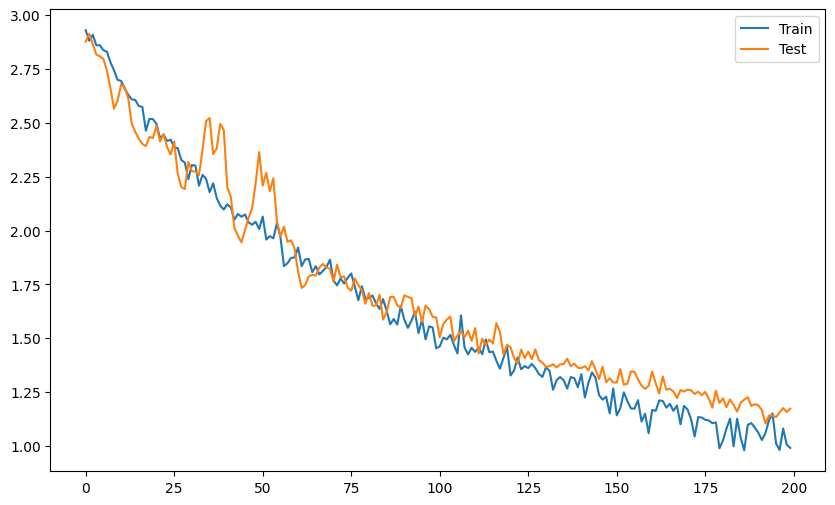

In [10]:
# Looking at the following plot, we can see that the model could continue 
# training to improve its performance. It seems that it has not reached 
# convergence yet.
plt.figure(figsize=(10, 6))
plt.plot(loss_train, label='Train')
plt.plot(loss_test, label='Test')
plt.legend()
plt.show()